<a href="https://colab.research.google.com/github/firaolkiya/solar-challenge-week1/blob/eda-sierraleone/notebooks/sierraleone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing dependencies

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

: 

view top 10 data

In [ ]:
ds =pd.read_csv("/content/sierraleone-bumbuna.csv")
ds.head(10)

check dimension of dataset

In [ ]:
ds.shape

Summary Statistics & Missing-Value Report

In [ ]:
print("Summary Statistics:")
ds.describe()


In [ ]:
print("\n\n describe each columns")
ds.describe(include='all')

In [ ]:
print("\nMissing Value Report:")
missing_values = ds.isna().sum()
print(missing_values)

total_rows = ds.shape[0]
print("\nColumns with >5% nulls:")
for column, count in missing_values.items():
  if count / total_rows > 0.05:
    print(f"- {column}: {count} ({count / total_rows:.2%})")

In [ ]:
ds.dropna(inplace=True,axis=1)
ds.shape

check for an overview of dataset and missing values

In [ ]:
def overview(ds):
  print("overview of dataset")
  print(ds.info())
  print("----------------------------------")
  print("total missing values in each column")
  print(ds.isna().sum())

print("data set before dropping columns")
overview(ds)


**Incorrect Entries (Negative Values)**

In [ ]:
# Select numerical columns to check for negative values
numerical_cols = ds.select_dtypes(include=np.number).columns

# Check for negative values in numerical columns
for col in numerical_cols:
    negative_values = ds[ds[col] < 0]
    if not negative_values.empty:
        print(f"Negative values found in column '{col}':")
        print(negative_values)
        print("\n")


ds[numerical_cols] = ds[numerical_cols].mask(ds[numerical_cols] < 0, 0)


In [ ]:
print("total missing values in each column")
ds.isna()


GET NUMERIC DATA

In [ ]:
numeric_df = ds.select_dtypes(include=['number'])
numeric_df.head(10)

OUTLIER DETECTION

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

CALCULATE Z SCORE

In [ ]:

# Function to detect outliers using Z-score
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > threshold]
    return outliers

# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Columns to check for missing values, outliers, and incorrect entries
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

print("\nChecking for missing values, outliers, and incorrect entries in specified columns:")

for col in columns_to_check:
    if col in ds.columns:
        print(f"\n--- Checking column: {col} ---")

        # Check for missing values
        missing_count = ds[col].isna().sum()
        print(f"Missing values: {missing_count}")

        if ds[col].dtype in ['int64', 'float64']:
            negative_count = (ds[col] < 0).sum()
            if negative_count > 0:
                print(f"Potential incorrect entries (negative values): {negative_count}")

            if ds[col].nunique() > 1: # Only perform outlier detection if there's more than one unique value
                outliers_iqr = detect_outliers_iqr(ds, col)
                print(f"Outliers detected using IQR: {len(outliers_iqr)}")
                if len(outliers_iqr) > 0:
                    print("Examples of detected outliers (IQR):")
                    print(outliers_iqr[col].head())

        else:
            print(f"Skipping outlier/incorrect entry check for {col} as it's not a numeric type.")
    else:
        print(f"\nColumn '{col}' not found in the dataset.")

Compute Z-scores for GHI, DNI, DHI, ModA, ModB, WS, WSgust; flag

In [ ]:
# Drop rows with missing values in the specified columns
ds_cleaned = ds.dropna(subset=columns_to_check).copy()

print("\nDataset after dropping rows with missing values in key columns:")
overview(ds_cleaned)

# Compute Z-scores for the specified columns
zscore_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

for col in zscore_cols:
  if col in ds_cleaned.columns and ds_cleaned[col].nunique() > 1: # Ensure column exists and has variance
    # Handle potential division by zero if standard deviation is 0
    std_dev = ds_cleaned[col].std()
    if std_dev == 0:
        ds_cleaned[f'{col}_ZScore'] = 0 # Assign Z-score of 0 if no variance
    else:
        ds_cleaned[f'{col}_ZScore'] = stats.zscore(ds_cleaned[col])
  else:
    print(f"Skipping Z-score calculation for {col} as it's not in the dataset or has no variance.")


# Flag rows with |Z| > 3 in any of the computed Z-score columns
zscore_columns = [f'{col}_ZScore' for col in zscore_cols if f'{col}_ZScore' in ds_cleaned.columns]

if zscore_columns:
    ds_cleaned['Outlier_Flag'] = (ds_cleaned[zscore_columns].abs() > 3).any(axis=1)
else:
    ds_cleaned['Outlier_Flag'] = False # No Z-score columns to flag

print("\nDataset with Z-scores and Outlier Flag:")
print(ds_cleaned[['GHI', 'GHI_ZScore', 'DNI', 'DNI_ZScore', 'DHI', 'DHI_ZScore', 'ModA', 'ModA_ZScore', 'ModB', 'ModB_ZScore', 'WS', 'WS_ZScore', 'WSgust', 'WSgust_ZScore', 'Outlier_Flag']].head())

print("\nRows flagged as potential outliers (based on |Z| > 3):")
print(ds_cleaned[ds_cleaned['Outlier_Flag']].head())

In [ ]:
import os

# Create the directory if it doesn't exist
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

# Define the output file path
output_file = os.path.join(output_dir, 'sierraleone.csv')

# Export the cleaned DataFrame to CSV
ds_cleaned.to_csv(output_file, index=False)

print(f"\nCleaned DataFrame exported to {output_file}")

Time Series Analysis

In [ ]:


# Define the columns to plot
time_series_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

# Create line plots
plt.figure(figsize=(15, 10))

for i, col in enumerate(time_series_cols):
    plt.subplot(len(time_series_cols), 1, i + 1)
    ds_time_indexed[col].plot(kind='line')
    plt.title(f'{col} vs. Timestamp')
    plt.ylabel(col)
    plt.xlabel('Timestamp')
    plt.grid(True)

plt.tight_layout()
plt.show()

# For demonstration, let's resample to daily averages for a clearer bar chart view
ds_daily = ds_time_indexed[time_series_cols].resample('D').mean()

plt.figure(figsize=(15, 10))

for i, col in enumerate(time_series_cols):
    plt.subplot(len(time_series_cols), 1, i + 1)
    ds_daily[col].plot(kind='bar')
    plt.title(f'Daily Average {col} vs. Timestamp')
    plt.ylabel(f'Average {col}')
    plt.xlabel('Timestamp')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
ds.shape

**Cleaning Impact**

In [ ]:

ds_cleaned['Cleaning_Flag'] = ds_cleaned['Outlier_Flag'].apply(lambda x: 'Post-Clean' if x else 'Pre-Clean')

# Group by Cleaning_Flag and calculate the mean of ModA and ModB
mod_comparison = ds_cleaned.groupby('Cleaning_Flag')[['ModA', 'ModB']].mean().reset_index()

print("\nAverage ModA and ModB pre/post cleaning:")
print(mod_comparison)

# Melt the DataFrame for plotting
mod_comparison_melted = mod_comparison.melt(id_vars='Cleaning_Flag', var_name='Module', value_name='Average Power')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=mod_comparison_melted, x='Cleaning_Flag', y='Average Power', hue='Module', palette='viridis')
plt.title('Average ModA and ModB Pre and Post Cleaning')
plt.ylabel('Average Power (W)')
plt.xlabel('Cleaning Status')
plt.grid(axis='y')
plt.show()

**Correlation & Relationship Analysis**

In [ ]:

# Heatmap of correlations
correlation_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
plt.figure(figsize=(8, 6))
sns.heatmap(ds_cleaned[correlation_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix (GHI, DNI, DHI, ModA, ModB)")
plt.show()

# Scatter plots
scatter_pairs = [
    ('WS', 'GHI'),
    ('WSgust', 'GHI'),
    ('WD', 'GHI'),
    ('RH', 'Tamb'),
    ('RH', 'GHI')
]

plt.figure(figsize=(15, 10))

for i, (x_col, y_col) in enumerate(scatter_pairs):
    if x_col in ds_cleaned.columns and y_col in ds_cleaned.columns:
        plt.subplot(2, 3, i + 1) # Arrange in 2 rows, 3 columns
        sns.scatterplot(data=ds_cleaned, x=x_col, y=y_col, alpha=0.5)
        plt.title(f'{y_col} vs. {x_col}')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.grid(True)
    else:
        print(f"Skipping scatter plot for {x_col} vs. {y_col} as one or both columns are not in the dataset.")

plt.tight_layout()
plt.show()

**Wind & Distribution Analysis**

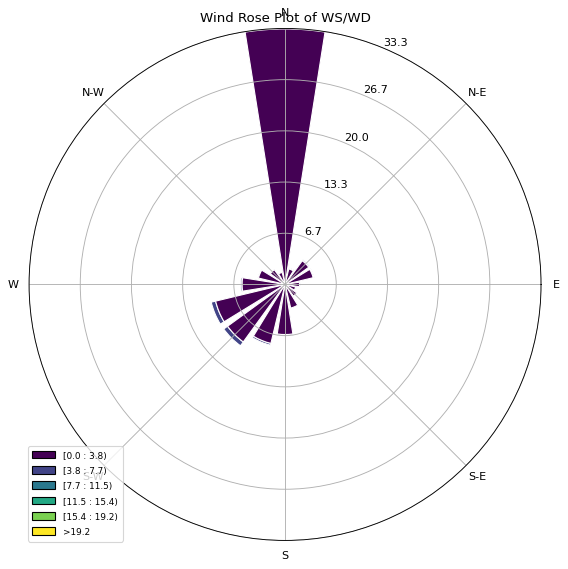

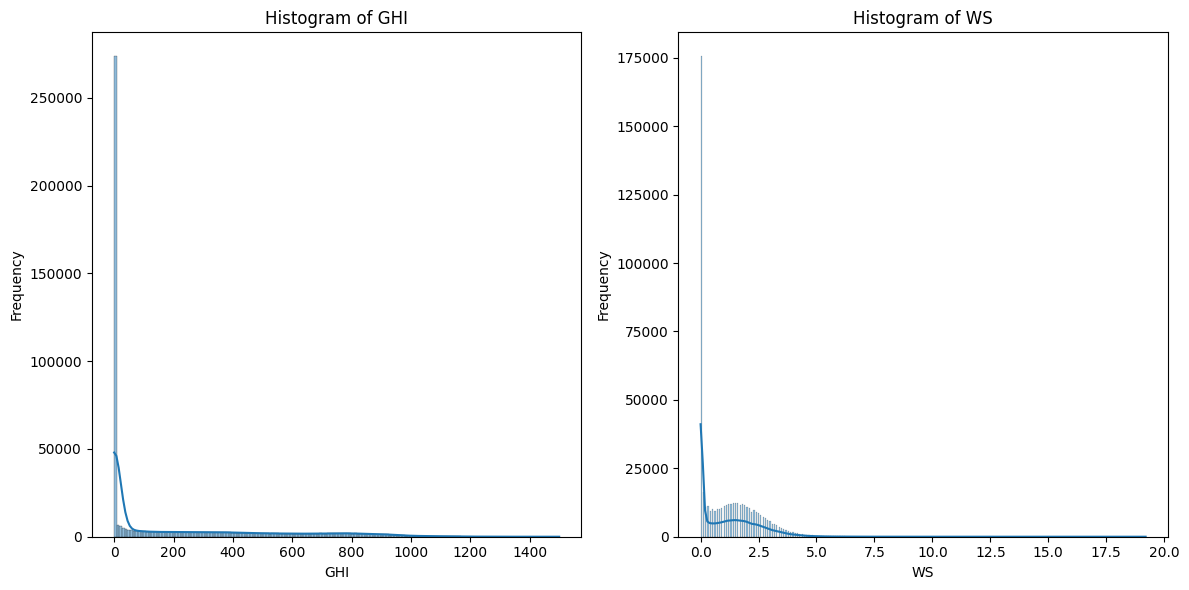

In [154]:

# Check if 'WD' and 'WS' columns exist
if 'WD' in ds_cleaned.columns and 'WS' in ds_cleaned.columns:
  # Requires windrose library: !pip install windrose
  !pip install windrose
  from windrose import WindroseAxes

  # Create a WindroseAxes instance
  ax = WindroseAxes.from_ax()
  # Plot the wind rose
  ax.bar(ds_cleaned['WD'], ds_cleaned['WS'], normed=True, opening=0.8, edgecolor='white')
  # Set the title
  ax.set_title('Wind Rose Plot of WS/WD')
  # Add legend
  ax.set_legend()
  plt.show()
else:
  print("Skipping Wind Rose plot as 'WD' or 'WS' column is not in the dataset.")


# Histograms for GHI and WS
plt.figure(figsize=(12, 6))

# Histogram for GHI
if 'GHI' in ds_cleaned.columns:
  plt.subplot(1, 2, 1)
  sns.histplot(ds_cleaned['GHI'], kde=True)
  plt.title('Histogram of GHI')
  plt.xlabel('GHI')
  plt.ylabel('Frequency')
else:
  print("Skipping GHI histogram as 'GHI' column is not in the dataset.")

# Histogram for WS
if 'WS' in ds_cleaned.columns:
  plt.subplot(1, 2, 2)
  sns.histplot(ds_cleaned['WS'], kde=True)
  plt.title('Histogram of WS')
  plt.xlabel('WS')
  plt.ylabel('Frequency')
else:
  print("Skipping WS histogram as 'WS' column is not in the dataset.")

plt.tight_layout()
plt.show()


**Temperature Analysis**

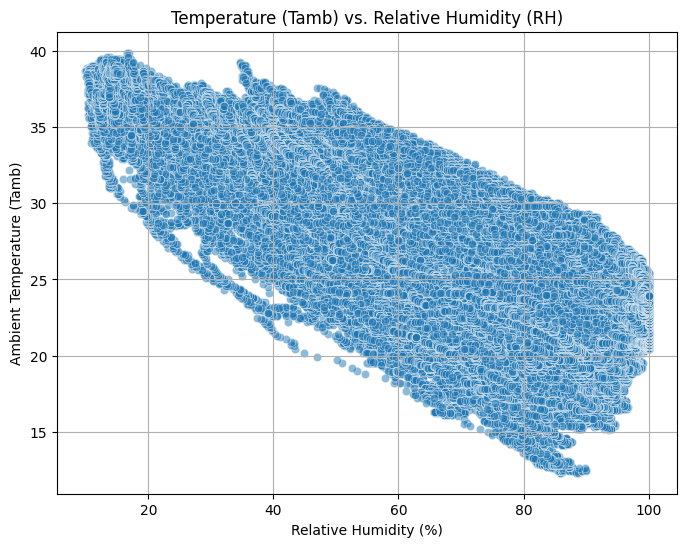

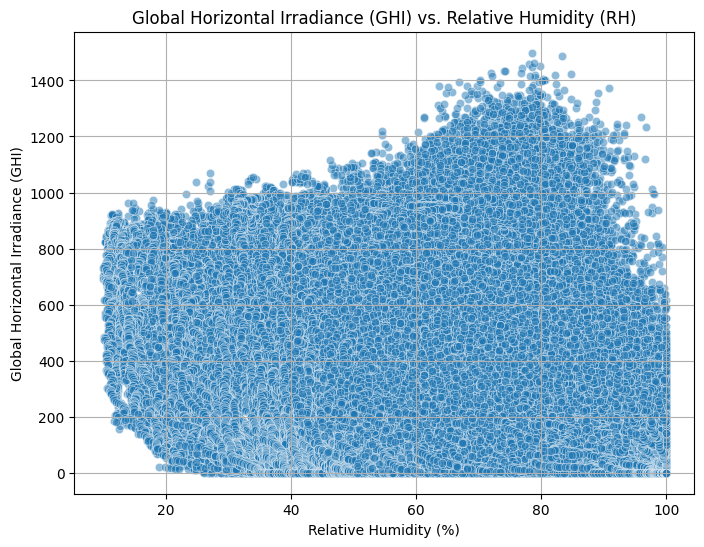

In [155]:
# Scatter plot for Tamb vs. RH
if 'Tamb' in ds_cleaned.columns and 'RH' in ds_cleaned.columns:
  plt.figure(figsize=(8, 6))
  sns.scatterplot(data=ds_cleaned, x='RH', y='Tamb', alpha=0.5)
  plt.title('Temperature (Tamb) vs. Relative Humidity (RH)')
  plt.xlabel('Relative Humidity (%)')
  plt.ylabel('Ambient Temperature (Tamb)')
  plt.grid(True)
  plt.show()
else:
  print("Skipping Temperature vs. RH scatter plot as 'Tamb' or 'RH' column is not in the dataset.")

# Scatter plot for GHI vs. RH
if 'GHI' in ds_cleaned.columns and 'RH' in ds_cleaned.columns:
  plt.figure(figsize=(8, 6))
  sns.scatterplot(data=ds_cleaned, x='RH', y='GHI', alpha=0.5)
  plt.title('Global Horizontal Irradiance (GHI) vs. Relative Humidity (RH)')
  plt.xlabel('Relative Humidity (%)')
  plt.ylabel('Global Horizontal Irradiance (GHI)')
  plt.grid(True)
  plt.show()
else:
  print("Skipping GHI vs. RH scatter plot as 'GHI' or 'RH' column is not in the dataset.")

***Bubble Chart***

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


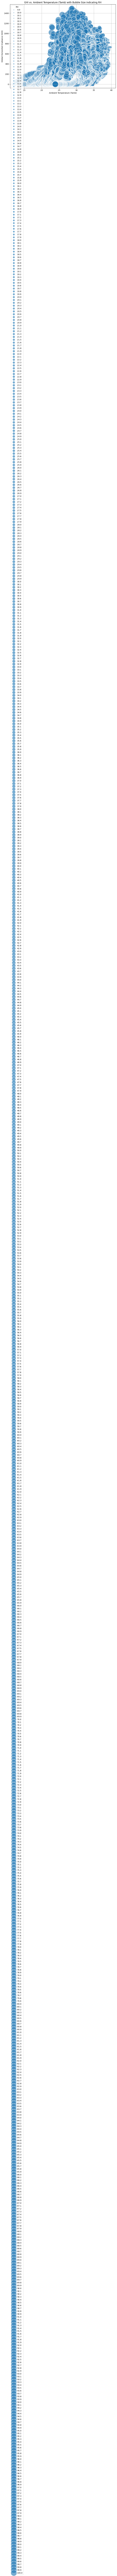

In [156]:
# prompt: GHI vs. Tamb with bubble size = RH or BP.

# Scatter plot with bubble size based on RH or BP
# Let's use RH as the size variable

# Check if required columns exist
if 'GHI' in ds_cleaned.columns and 'Tamb' in ds_cleaned.columns and ('RH' in ds_cleaned.columns or 'BP' in ds_cleaned.columns):

    size_col = 'RH' if 'RH' in ds_cleaned.columns else ('BP' if 'BP' in ds_cleaned.columns else None)

    if size_col:
        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=ds_cleaned, x='Tamb', y='GHI', size=size_col, alpha=0.6, sizes=(20, 1000), legend='full')
        plt.title(f'GHI vs. Ambient Temperature (Tamb) with Bubble Size indicating {size_col}')
        plt.xlabel('Ambient Temperature (Tamb)')
        plt.ylabel('Global Horizontal Irradiance (GHI)')
        plt.grid(True)
        plt.show()
    else:
        print("Skipping bubble plot as neither 'RH' nor 'BP' column is available for bubble size.")

else:
    print("Skipping bubble plot as required columns ('GHI', 'Tamb', and either 'RH' or 'BP') are not in the dataset.")

Visualize columns

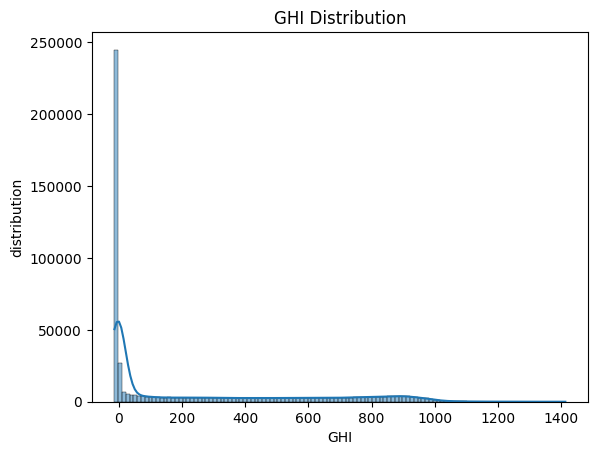

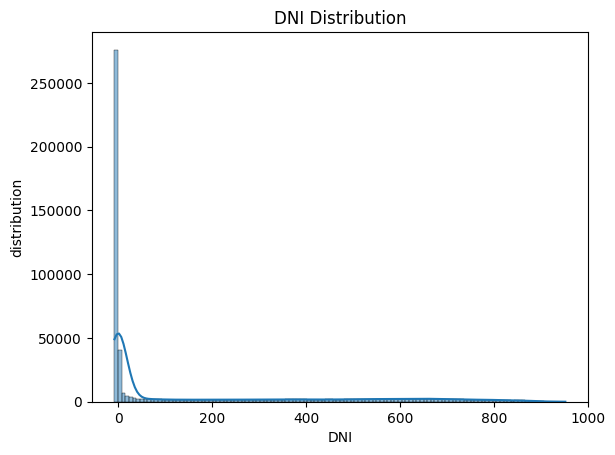

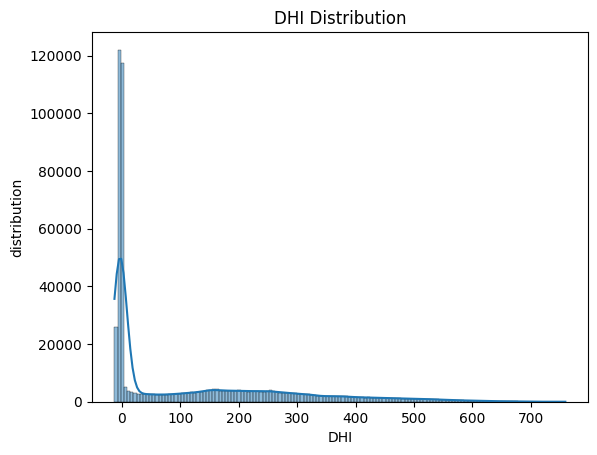

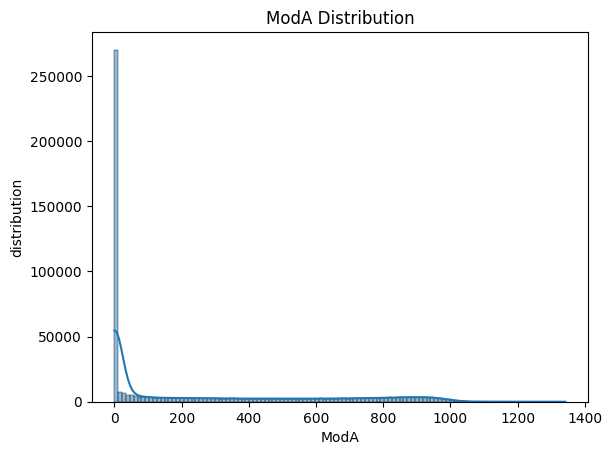

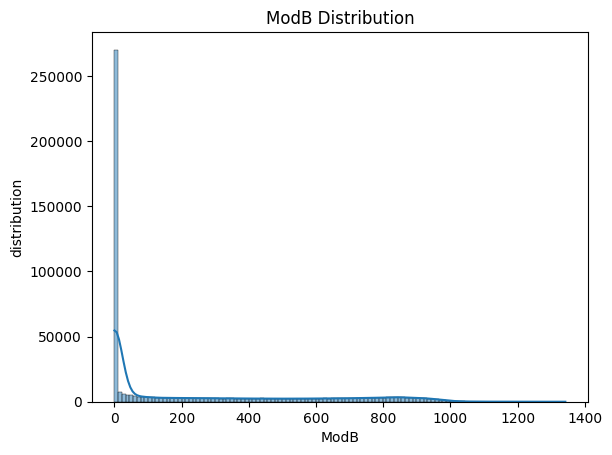

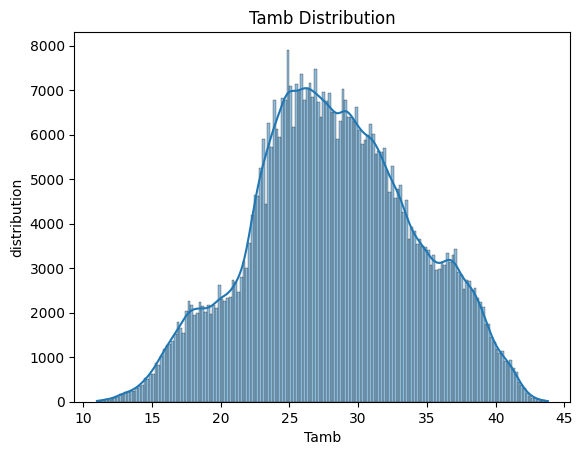

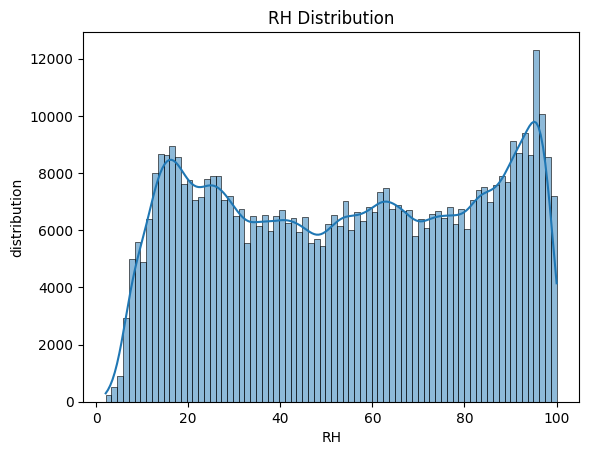

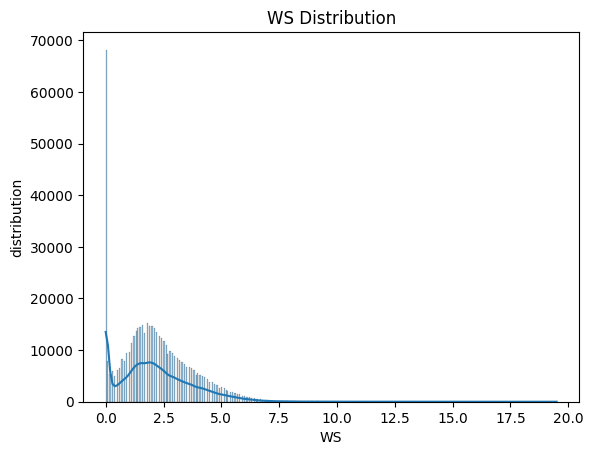

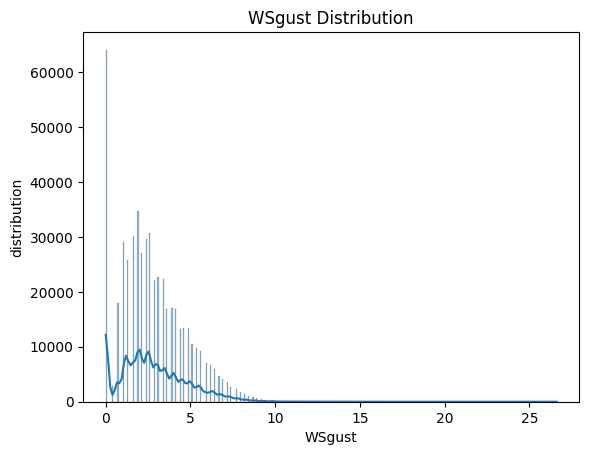

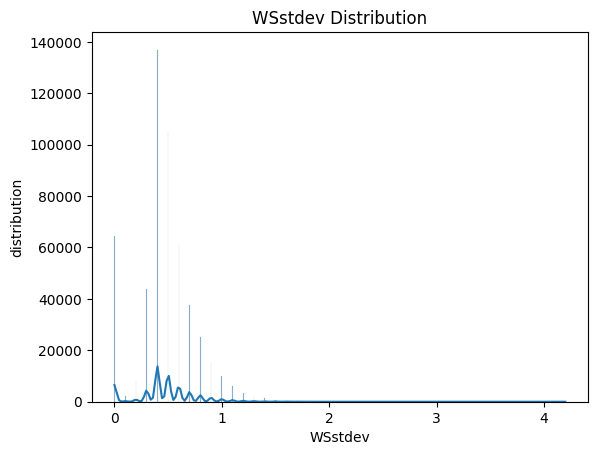

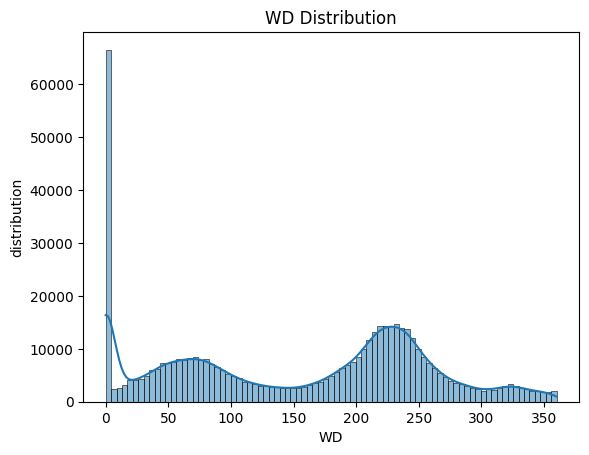

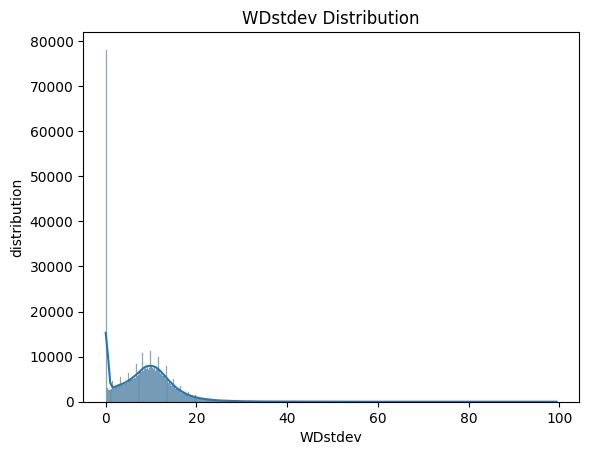

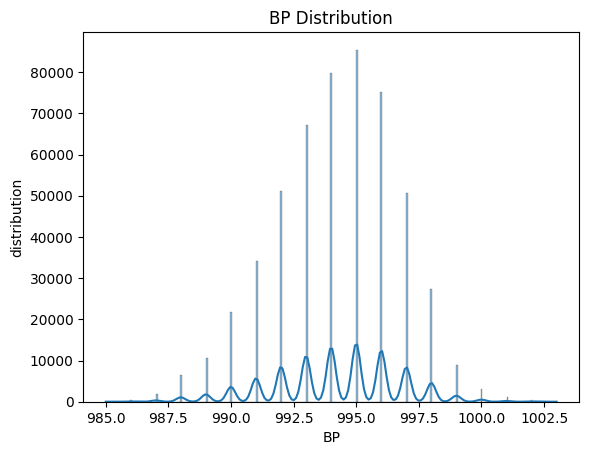

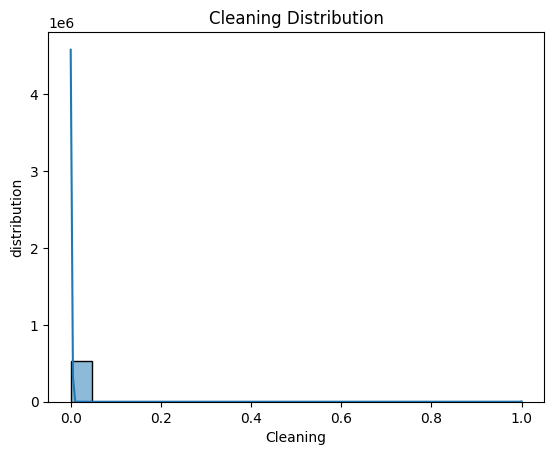

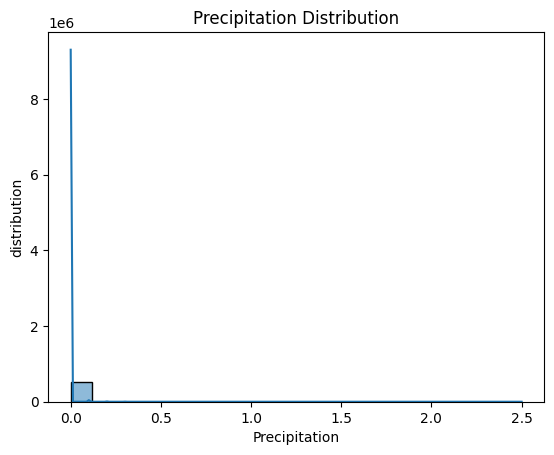

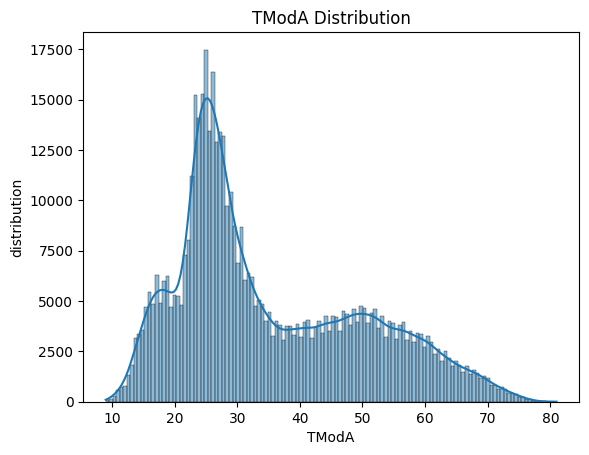

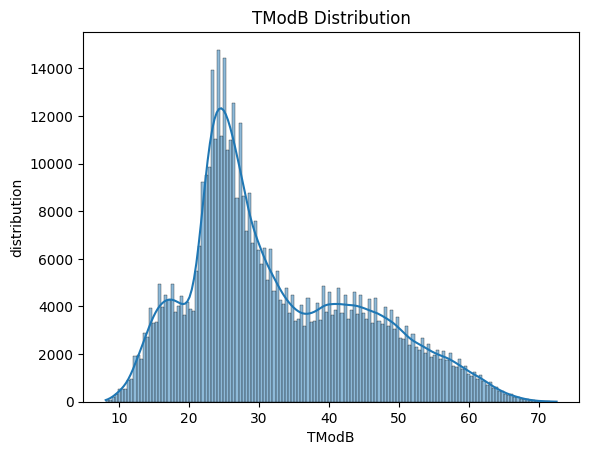

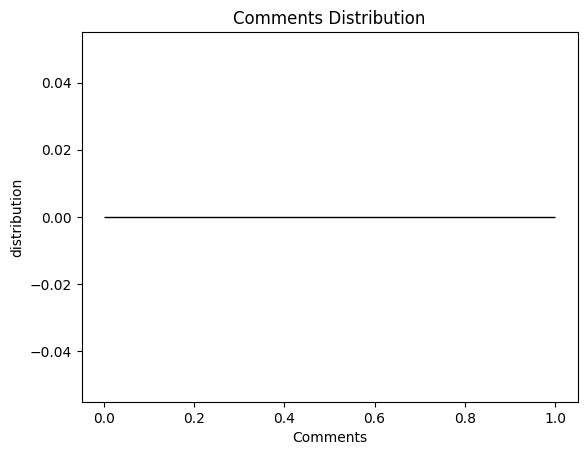

In [47]:
for col in numeric_df:
    sns.histplot(numeric_df[col], kde=True)
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("distribution")
    plt.show()

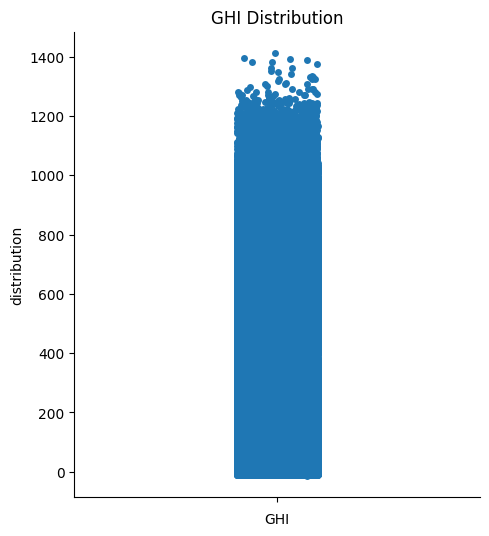

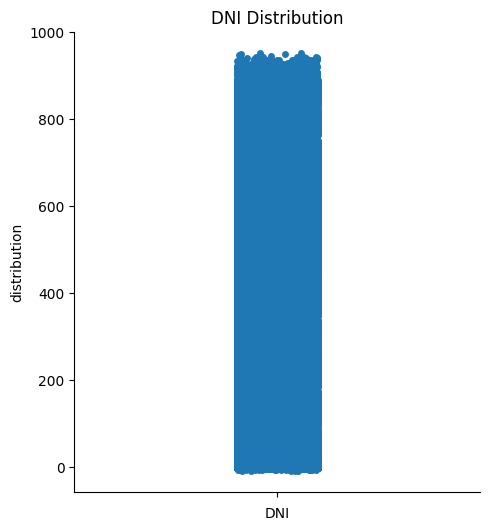

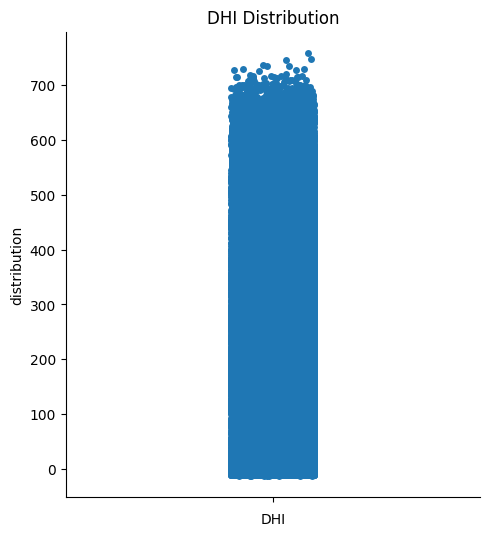

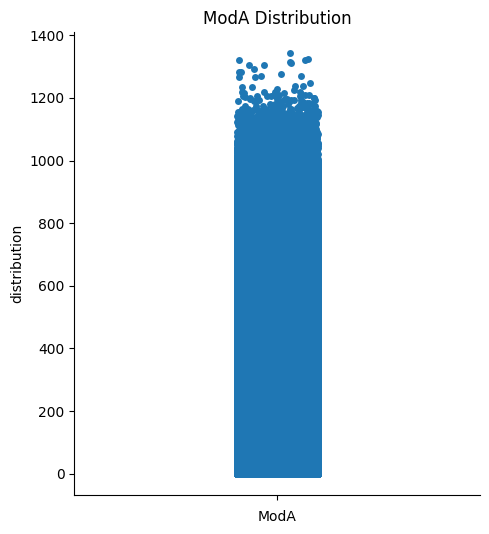

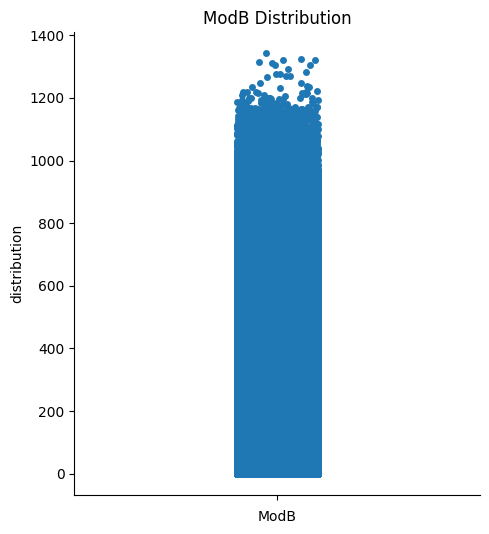

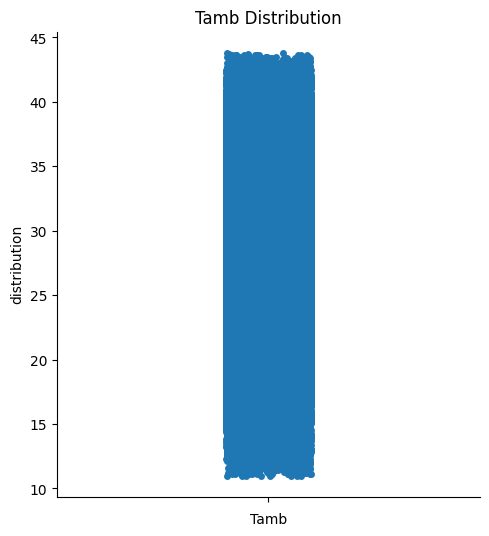

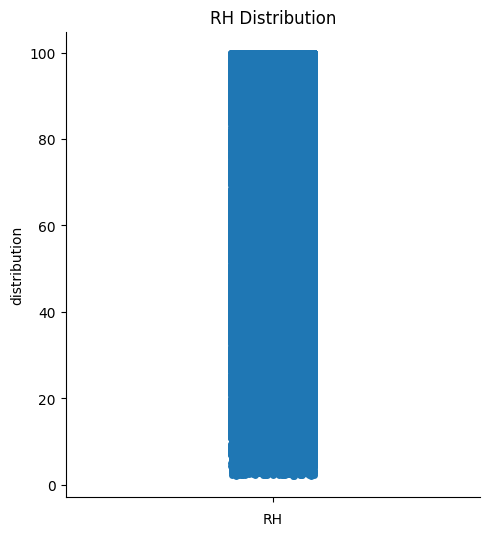

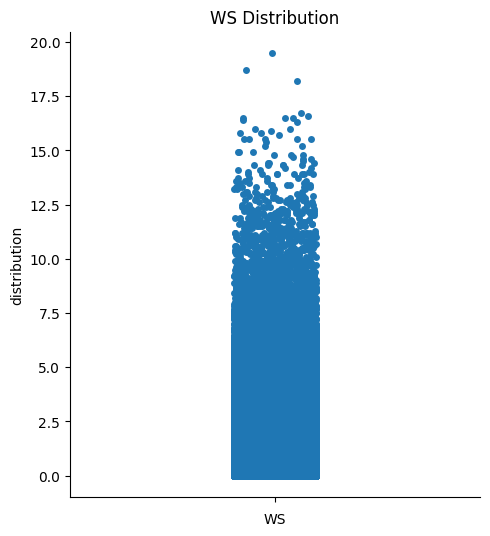

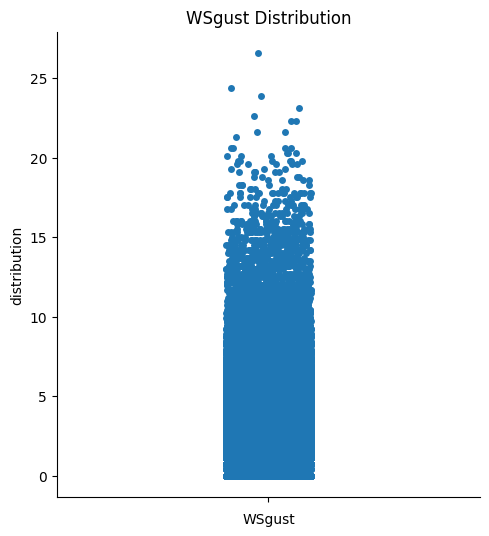

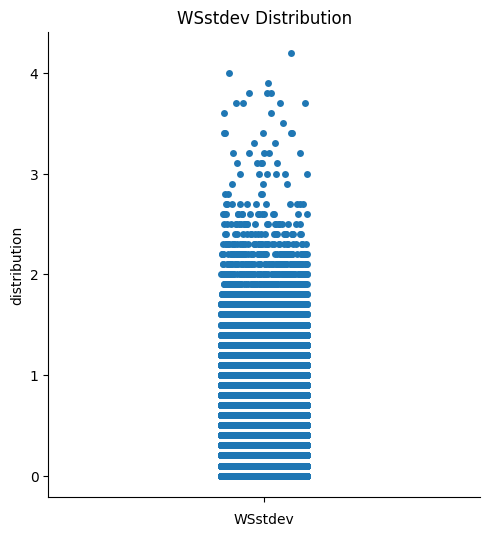

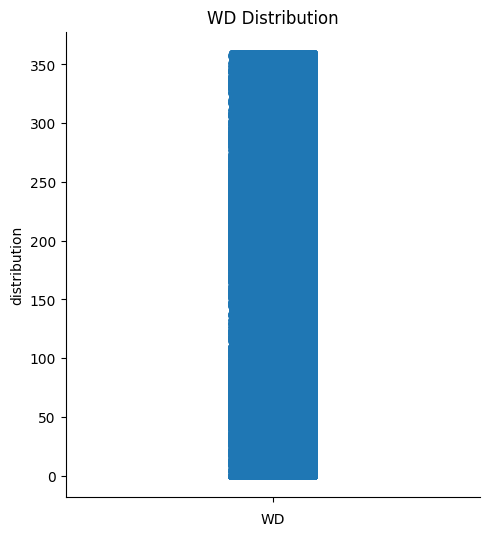

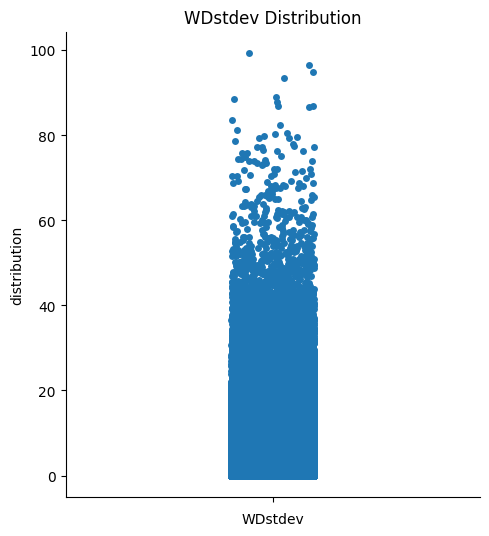

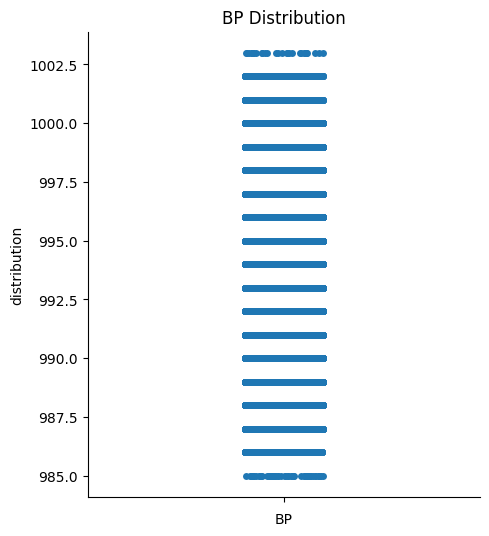

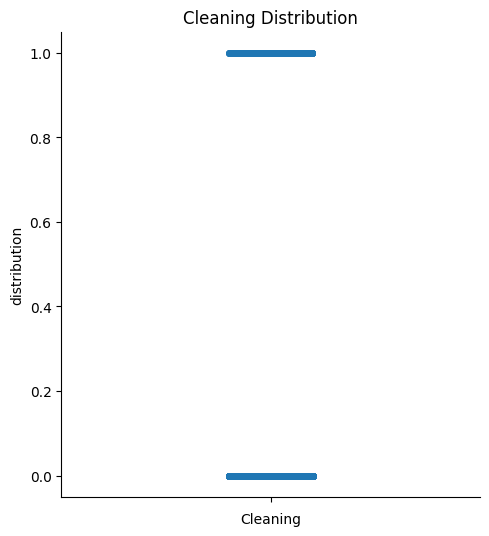

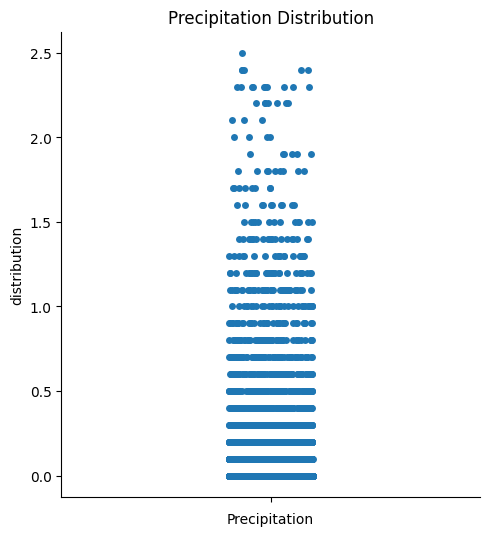

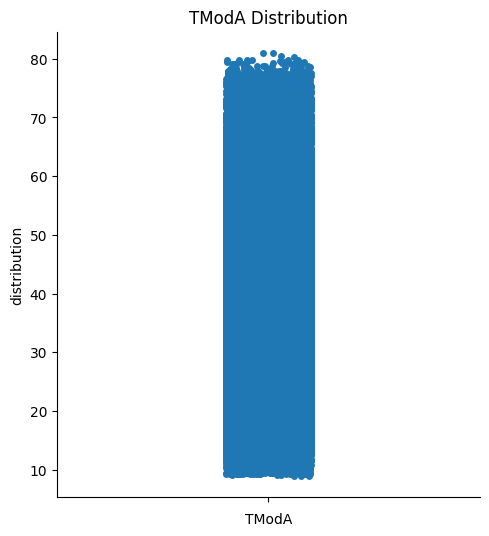

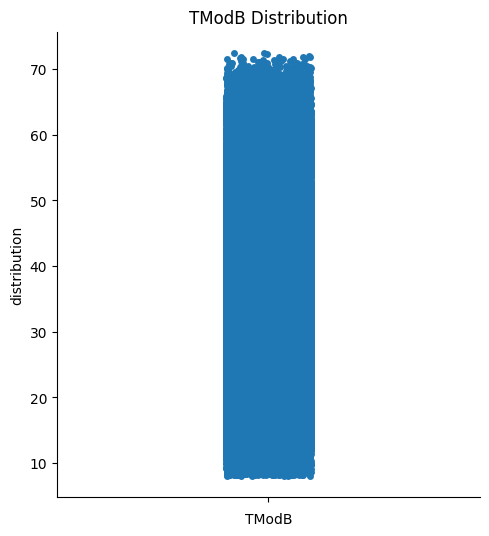

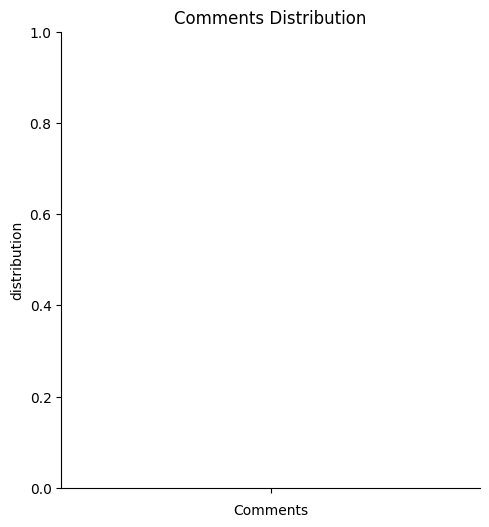

In [52]:
for col in numeric_df:
    sns.catplot(numeric_df[col])
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("distribution")
    plt.show()

Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'Comments'],
      dtype='object')


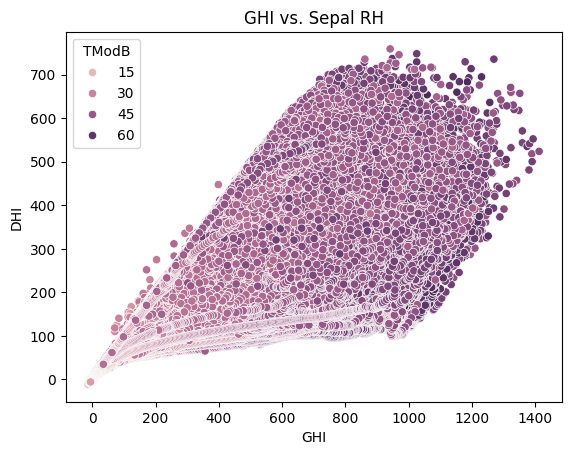

In [60]:
print(ds.columns)
sns.scatterplot(data=ds, x="GHI", y="DHI", hue="TModB")
plt.title("GHI vs. Sepal RH")
plt.show()
